In [182]:
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import json

## Synthetic ts

In [183]:
def generate_ARHT(t_0, T, num_harmonics = 0, coeffs = None, periods = None, max_period = 100, min_period = 0,
                  trend = False, power = 0, const = 0, var = 1):
    signal = np.zeros(T - t_0 + 1)
    t = np.arange(t_0,T+1)
    if num_harmonics: #todo: Check consistant number of harmonics length of coeffs and periods
        if coeffs is None:
            coeffs = 2 * np.random.random(harmonics_components) + 0.3
        if periods is None:
            sine_periods = ((max_period-min_period)* np.random.random(num_harmonics) + min_period)
        for i in range(num_harmonics): 
            signal += coeffs[i] * np.sin((t/(T - t_0 + 1))*periods[i]*2.0*np.pi)
    if trend: #add more trend types
        signal += t**power
    if const: 
        signal += const
    noise = np.random.normal(0.0, np.sqrt(var), T - t_0 + 1)
    noisy_ts = signal + noise
    return noisy_ts, signal



In [188]:
def generate_synthetic(cp_type, cp_number, T, nh, trend, noise_var, power = 0): 
    ts = np.array([])
    tm = np.array([])
    if cp_type == 'struct': 
        const = np.zeros(cp_number)
        coeffs = np.tile(np.random.random(nh)*7, cp_number).reshape(cp_number,nh)
        periods = np.zeros((cp_number, nh))
        for i in range(cp_number): 
            if i%2==0: 
                periods[i, :] = 5 + np.random.random(nh) * 30
            else: 
                periods[i, :] = 5 + np.random.random(nh) * 70
    if cp_type == 'mean': 
        const = np.random.random(cp_number) * 10
        coeffs = np.tile(np.random.random(nh)*7, cp_number).reshape(cp_number,nh)
        periods = np.tile(5+np.random.random((nh))*100, cp_number).reshape(cp_number,nh)
    if cp_type == 'energy': 
        const = np.zeros(cp_number)
        periods = np.tile(5+np.random.random((nh))*100, cp_number).reshape(cp_number,nh)
        coeffs = np.zeros((cp_number, nh))
        for i in range(cp_number): 
            if i%2==0: 
                coeffs[i, :] = np.random.random() * 7 * np.ones(nh)
            else: 
                coeffs[i, :] = np.random.random() * 5 * np.ones(nh)
    param = {}
    for i in range(0, cp_number):
        key = 'ts_{}'.format(i)
        param[key] = {'periods': periods[i], 'coeffs': coeffs[i], 'conts': const[i], 'noice': noise_var, 'trend_power': power}
        ts_, tm_ = generate_ARHT(i*T + 1, (i+1)*T, num_harmonics = nh, coeffs = coeffs[i], periods = periods[i], 
                                 max_period = 100, min_period = 0, trend = trend, power = power, const = const[i], var = noise_var)
        ts = np.append(ts, ts_)
        tm = np.append(tm, tm_)
    start = np.arange(0, cp_number+1) * T
    end = np.arange(1, cp_number+2) * T - 1
    new_labels = pd.DataFrame(start)
    new_labels[1] = end
    return ts, tm, new_labels, param

        
        
        
        
        

In [189]:
def json_converter(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, datetime.datetime):
            return obj.__str__()

In [195]:
cp_type = 'energy'
cp_number = 5 
T = 1000
nh = 3 
trend = False
noise_var = 0.01
samples = 20
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'synth')
for sample in range(samples): 
    ts, tm, labels, param = generate_synthetic(cp_type, cp_number, T, nh, trend, noise_var, power = 0)
    df = pd.DataFrame(ts)
    df.reset_index(inplace=True)
    df.to_csv(path_or_buf=os.path.join(data_path, '{}{}_ts.csv'.format(cp_type, sample)), index=False, header=False)
    df = pd.DataFrame(tm)
    df.reset_index(inplace=True)
    df.to_csv(path_or_buf=os.path.join(data_path, '{}{}_tm.csv'.format(cp_type, sample)), index=False, header=False)
    labels.to_csv(path_or_buf=os.path.join(data_path, '{}{}_labels.csv'.format(cp_type, sample)), index=False, header=False)
    with open(os.path.join(data_path, '{}{}_param.csv'.format(cp_type, sample)), 'w') as file:
        json.dump(param, file, default=json_converter)
    

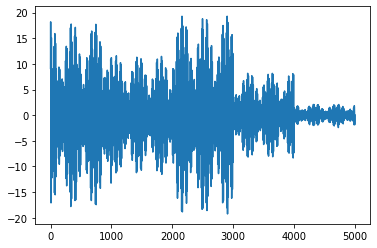

In [196]:
plt.plot(ts)

In [131]:
dataset = 'energy'
T = 1000
nh = 3
var = 0.01
N = 100
trend = False 
power = 0.35
const = 0
# coeffs = np.random.random(nh) *10
periods = 5 + np.random.random(nh) * 100
print(periods)
param = np.zeros((N+1, nh*2))
ts = np.array([])
tm = np.array([])
for i in range(0, N+1): 
    param_ = []
    if i%2 == 0: 
#         const = np.random.random() * 10
        coeffs = np.random.random()  * 7 * np.ones(nh)
#         periods = 5 + np.random.random(nh) * 30
    else: 
#         const = np.random.random() * 10
        coeffs = np.random.random() * 5 * np.ones(nh)
#         periods = 5 + np.random.random(nh) * 70
    ts_, tm_ = generate_ARHT(i*T + 1, (i+1)*T, num_harmonics = nh, coeffs = coeffs, periods = periods, max_period = 100, min_period = 0,
                      trend = trend, power = power, const = const, var = var)
    param[i] = coeffs.tolist() + periods.tolist()
    ts = np.append(ts, ts_)
    tm = np.append(tm, tm_)
    
df = pd.DataFrame(ts)
df.reset_index(inplace=True)
df.to_csv(path_or_buf='Benchmark/Data/Synthetic {}/ts.csv'.format(dataset), index=False, header=False)
df = pd.DataFrame(tm)
df.reset_index(inplace=True)
df.to_csv(path_or_buf='Benchmark/Data/Synthetic {}/tm.csv'.format(dataset), index=False, header=False)

df = pd.DataFrame(param)
df.to_csv(path_or_buf='Benchmark/Data/Synthetic {}/param.csv'.format(dataset), index=False, header=False)

start = np.arange(0, N+1) * T
end = np.arange(1, N+2) * T - 1
new_labels = pd.DataFrame(start)
new_labels[1] = end
new_labels.to_csv(path_or_buf='Benchmark/Data/Synthetic {}/labels.csv'.format(dataset), index=False, header=False)


[84.11356785 52.80681308 83.06081662]


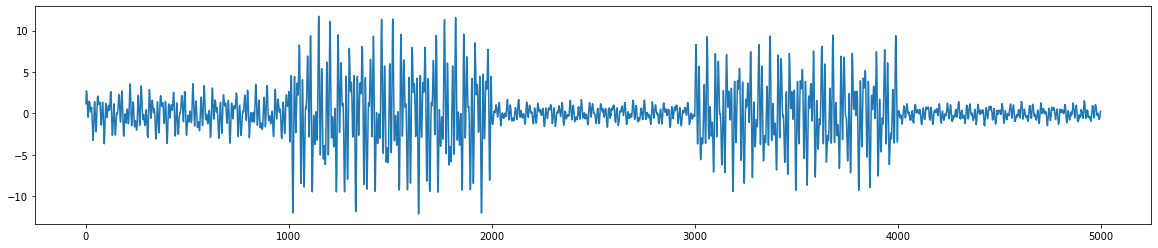

In [73]:
plt.figure(figsize=[20,4])
plt.plot(ts[:5000])

## Human activity


In [75]:
# Norm of coordinates
dataset = '03'
person = 102
df = pd.read_csv("Data/HascToolDataPrj/SampleData/0_sequence/person{}/HASC10{}.csv".format(person,dataset), header=None)
df.reset_index(inplace=True)
data_array = df[[1,2,3]].values
ts = np.linalg.norm(data_array, 2, 1)
ts = pd.DataFrame(ts)
ts.reset_index(inplace=True)
ts.to_csv(path_or_buf='Benchmark/Data/HA {}/ts.csv'.format(dataset), columns=['index', 0], index=False, header=False)


# Labels
labels = pd.read_csv('Data/HascToolDataPrj/SampleData/0_sequence/person{}/HASC10{}.label'.format(person,dataset), skiprows=1, header=None)
labels.head()
new_labels = []
for i, row in labels.iterrows():
    act = row[2]
    start = df[df[0]<=row[0]].index.values[-1]
    end = df[df[0]<=row[1]].index.values[-1]
    new_labels.append((start, end, act))
new_labels = pd.DataFrame(new_labels)
new_labels.to_csv(path_or_buf='Benchmark/Data/HA {}/labels.csv'.format(dataset), index=False, header=False)



In [22]:
#original
dataset = 1
for i in [1,2,3]:
    df = pd.read_csv("Data/HascToolDataPrj/SampleData/0_sequence/person107/HASC10{}.csv".format(dataset), header=None)
    df.reset_index(inplace=True)
    df.head()
    df.to_csv(path_or_buf='Data/Processed data/Human activity {}/{}.csv'.format(dataset, i), columns=['index', i], index=False, header=False)
    

In [23]:
labels = pd.read_csv('Data/HascToolDataPrj/SampleData/0_sequence/person107/HASC10{}.label'.format(dataset), skiprows=1, header=None)
new_labels = []
for i, row in labels.iterrows():
    act = row[2]
    start = df[df[0]<=row[0]].index.values[-1]
    end = df[df[0]<=row[1]].index.values[-1]
    new_labels.append((start, end, act))
new_labels = pd.DataFrame(new_labels)
new_labels.to_csv(path_or_buf='Data/Processed data/Human activity {}/labels.csv'.format(dataset), index=False, header=False)

## EEG Eye Activity Data 
http://archive.ics.uci.edu/ml/datasets/EEG+Eye+State

In [19]:
data = arff.loadarff('EEG Eye State.arff')
df = pd.DataFrame(data[0])

df.head()

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,b'0'
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,b'0'
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,b'0'
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,b'0'
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,b'0'


In [69]:
df['eyeDetection']

0        b'0'
1        b'0'
2        b'0'
3        b'0'
4        b'0'
5        b'0'
6        b'0'
7        b'0'
8        b'0'
9        b'0'
10       b'0'
11       b'0'
12       b'0'
13       b'0'
14       b'0'
15       b'0'
16       b'0'
17       b'0'
18       b'0'
19       b'0'
20       b'0'
21       b'0'
22       b'0'
23       b'0'
24       b'0'
25       b'0'
26       b'0'
27       b'0'
28       b'0'
29       b'0'
         ... 
14950    b'0'
14951    b'0'
14952    b'0'
14953    b'0'
14954    b'0'
14955    b'0'
14956    b'0'
14957    b'0'
14958    b'0'
14959    b'1'
14960    b'1'
14961    b'1'
14962    b'1'
14963    b'1'
14964    b'1'
14965    b'1'
14966    b'1'
14967    b'1'
14968    b'1'
14969    b'1'
14970    b'1'
14971    b'1'
14972    b'1'
14973    b'1'
14974    b'1'
14975    b'1'
14976    b'1'
14977    b'1'
14978    b'1'
14979    b'1'
Name: eyeDetection, Length: 14980, dtype: object

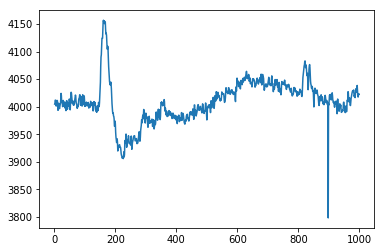

In [70]:
plt.plot(df['F7'][1:1000])

## Car sensor

In [35]:
df = pd.read_csv("Car_TEST.tsv",sep='\t')
df.head()

,4,1.4260641,1.3833925,1.338319,1.3285069,1.3580695,1.3450543,1.3023133,1.2589981,1.2476423,...,1.3539033,1.3568707,1.3517237,1.3470059,1.3200568,1.2924769,1.304151,1.3453263,1.3905243,1.3905243.1
0,3,1.627373,1.590235,1.553101,1.515983,1.475730,1.431632,1.392192,1.355006,1.317838,...,1.431967,1.468652,1.505367,1.541229,1.569503,1.600594,1.637504,1.629394,1.584566,1.584566
1,2,1.651212,1.611446,1.572121,1.532942,1.493927,1.454606,1.414984,1.428797,1.407167,...,1.627291,1.623406,1.583851,1.550975,1.548918,1.547226,1.525657,1.533493,1.572569,1.611891
2,3,2.027566,1.990906,1.944900,1.929431,1.914625,1.874753,1.834887,1.795030,1.755179,...,1.764289,1.803875,1.841988,1.877844,1.917510,1.963942,2.003889,2.046784,2.040575,2.033914
3,4,1.724875,1.680044,1.633172,1.669576,1.633641,1.587976,1.543541,1.498258,1.486019,...,1.526239,1.535510,1.574697,1.602634,1.608364,1.649816,1.694550,1.728753,1.683934,1.683934
4,3,1.642850,1.647981,1.616345,1.578606,1.540155,1.495776,1.451633,1.408836,1.370976,...,1.719056,1.709985,1.701230,1.692796,1.684683,1.676893,1.669428,1.662289,1.655479,1.648999


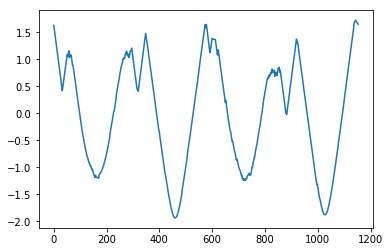

In [52]:
plt.plot(np.append(np.array(df.iloc[0][1:]), np.array(df.iloc[4][1:])))

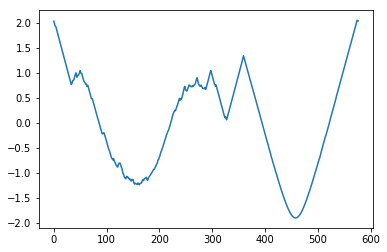

In [43]:
plt.plot(np.array(df.iloc[2][1:]))

In [32]:
os.getcwd()

'/Users/arwaalanqary/Dropbox (MIT)/MIT/Anomaly/Experiments'

In [46]:
np.append(np.array([1,2,3]), np.array([1,2,3]))

array([1, 2, 3, 1, 2, 3])

## ECG Heart Rate

https://www.physionet.org/challenge/2013/

In [54]:
df = pd.read_csv("NonInvasiveFetalECGThorax1_TRAIN.tsv",sep='\t')
df.head()

,33,3.0577079,2.9885631,2.821472,2.6392369,2.4456015,2.1598024,1.7604417,1.2885524,0.77969192,...,0.95861238,1.1266078,1.3201244,1.5226308,1.7262525,1.9814184,2.3291505,2.6963492,2.9390075,3.0347465
0,9,3.551183,3.538439,3.496559,3.467801,3.425732,3.294089,3.069612,2.768019,2.384278,...,1.048056,1.165939,1.321963,1.557507,1.857872,2.181923,2.531168,2.914332,3.243796,3.450888
1,10,3.543798,3.492157,3.372021,3.203759,2.987730,2.720849,2.415307,2.095017,1.819433,...,2.197438,2.506959,2.789635,3.028782,3.181554,3.302693,3.420687,3.549091,3.680165,3.776992
2,21,3.395535,3.360977,3.277669,3.144162,2.939326,2.656123,2.305517,1.910022,1.507525,...,1.207758,1.472210,1.777132,2.096057,2.389526,2.658084,2.893496,3.081306,3.221843,3.339746
3,3,3.241202,3.205867,3.154977,3.128858,3.082867,2.970339,2.765154,2.461359,2.069992,...,0.980121,1.155265,1.361519,1.605221,1.887810,2.209286,2.556973,2.891310,3.149312,3.290653
4,1,3.173411,3.163903,3.145480,3.076536,2.938647,2.679500,2.306256,1.849825,1.327430,...,0.955710,1.117334,1.305097,1.535638,1.813734,2.125116,2.457900,2.778817,3.006432,3.082497


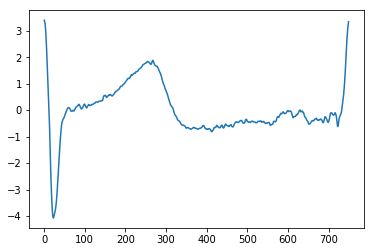

In [62]:
plt.plot(np.array(df.iloc[2][1:]))

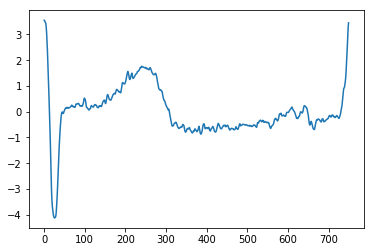

In [61]:
plt.plot(np.array(df.iloc[0][1:]))

## Human activity 